In [63]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, plot_confusion_matrix, precision_recall_curve
from sklearn.utils import shuffle
import seaborn as sns
from PIL import Image
from tensorflow.keras import backend as K    
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Methods for Experiments

In [64]:
# data distribution
def get_distr(targets, labels):
    vals = {}
    for label in labels.keys():
        vals[label] = 0
    
    for target in targets:
        vals[target] += 1
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    langs = labels.values()
    students = vals.values()
    ax.bar(langs,students)
    plt.show()

In [65]:
# Image normalization
img_dim = 224
def normalize_images(d, curr_dir):
    """normalize all images inside dictionary"""
    images = np.empty((len(d['target']), img_dim, img_dim, 3))

    for i in range(len(d['filename'])):
        image = Image.open(curr_dir + d['filename'][i])

        # resize image shape
        image = image.resize((img_dim, img_dim))

        # convert to grayscale
        image = image.convert('RGB')

        images[i] = np.array(image)

    # normalize values
    images = images / 255.0
    return images

In [66]:
# Data Augmentation
aug_count = 15
def augment_images(images, targets):
    data_augmentation = tf.keras.Sequential([
      layers.experimental.preprocessing.RandomFlip("horizontal", dtype='float64'),
      layers.experimental.preprocessing.RandomRotation(0.05, dtype='float64')
    ])
    
    aug_images = np.empty((len(targets) * (aug_count + 1), img_dim, img_dim, 3))
    new_targets = []
    
    
    for i in range(len(targets)):
        image = tf.expand_dims(images[i], 0)
        for j in range(0, aug_count):
            new_image = data_augmentation(image)
            new_targets.append(targets[i])
            aug_images[len(new_targets) - 1] = new_image[0]
        
        # add base image
        new_targets.append(targets[i])
        aug_images[len(new_targets) - 1] = images[i]
    
    return np.asarray(aug_images), new_targets

In [67]:
# Get data to test on
def split_data(images, targets, split_size):
    x_train, x_test, y_train, y_test = train_test_split(images, targets, test_size=split_size, random_state=0)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=split_size, random_state=0)
    y_train = np.asarray(y_train)
    y_val = np.asarray(y_val)
    y_test = np.asarray(y_test)
    
    return x_train, y_train, x_val, y_val, x_test, y_test

In [68]:
def graph_correlation(images, targets, classes):
    reshaped_images = np.empty((len(targets), img_dim * img_dim * 2))
    for i in range(len(targets)):
        reshaped_images[i] = images[i].ravel()

    pca = PCA(n_components=2)
    redData = pca.fit_transform(reshaped_images)
    # append target values to reduced data
    redData = np.append(redData, np.asarray(targets).reshape(-1, 1), axis=1)
     # create scatter plot of reduced data
    # add scatter plot for each of the target values
    for curr in classes:
        currClass = np.where(np.asarray(d['target']) == curr)
        plt.scatter(redData[:, 0][currClass], redData[:, 1][currClass])
        plt.legend(classes)

In [69]:
def convert_pred(y_pred, threshold):
    new_pred = np.empty((y_pred.size), dtype='int32')
    for i in range(y_pred.size):
        if y_pred[i] >= threshold:
            new_pred[i] = 1
        else:
            new_pred[i] = 0
    
    return new_pred

Results functions

In [70]:
# accuracy and loss plots
def plot_results(history, title):
    # plot accuracy and loss curves
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))

    axs[0].plot(history.history['accuracy'], label='training accuracy')
    axs[0].plot(history.history['val_accuracy'], label = 'val accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_title((title + ' Accuracy'))
    axs[0].set_ylim([0.5, 1])
    axs[0].legend(loc='lower right')

    axs[1].plot(history.history['loss'], label='training loss')
    axs[1].plot(history.history['val_loss'], label = 'val loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].set_title((title + ' CNN Loss'))
    axs[1].set_ylim([0, 1])
    axs[1].legend(loc='lower right')

In [88]:
# ROC Plots
def plot_ROC(y_test, y_pred, title):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_val = auc(fpr, tpr)

    plt.plot(fpr,tpr) 
    plt.plot([0, 1], [0, 1], linestyle='dashed')
    plt.axis([-0.05, 1.05, -0.05, 1.05]) 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    title += "\nAUC: " + str(round(auc_val, 4))
    plt.title(title)
    plt.show()

In [72]:
# Confusion Matrix
def plot_cm(y_test, y_pred, title):
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm)
    sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt="d")
    plt.imshow(cm)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)

In [73]:
def plot_pr(y_test, y_pred, title):
    prec, recall, _ = precision_recall_curve(y_test, y_pred)
    plt.plot(recall, prec)
    plt.ylim([0, 1])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title + " Precision vs Recall")

# Part 0: Load in data

In [74]:
# covid/pneumonia
data = []
with open("metadata.csv") as file:
    for row in csv.reader(file):
        data.append(row)

data = data[1:]

# pneumonia/healthy
# format: (file location, healthy/pneumonia(0/1))
ph_files = [('train/Normal', 0), 
         ('train/Pneumonia', 1),
         ('test/Normal', 0), 
         ('test/Pneumonia', 1),
         ('val/Normal', 0), 
         ('val/Pneumonia', 1),]

COVID/Pneumonia

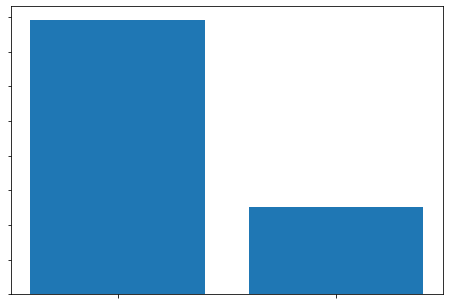

In [75]:
ch = {'filename': [], 'target': []}

# covid/pneumonia data
for image in data:
    # skip volume data
    if image[22] == "volumes":
        continue
    
    # ignore CT scan data
    if image[19] == "CT":
        continue
    
    diagnosis1 = image[4].split("/")
    diagnosis = diagnosis1[len(diagnosis1) - 1].lower()
    # set target based on meta data
    if diagnosis == "covid-19":
        # if it is COVID-19
        ch['filename'].append(image[23])
        ch['target'].append(1)
        
# healthy from pneumonia/healthy
for file in ph_files:
    if "normal" in file[0].lower():
        dir_path = os.path.abspath(os.getcwd())
        dir_path = dir_path + "/chest_xray/" + file[0]
        list = os.listdir(dir_path)
        for pic in list:
            if '.DS_Store' not in pic:
                ch['filename'].append(pic)
                ch['target'].append(0)

# get distribution
labels = {0: "Healthy", 1: "COVID"}
get_distr(ch['target'], labels)


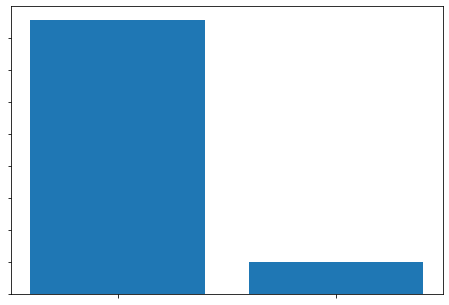

In [76]:
cp = {'filename': [], 'target': []}

# covid/pneumonia data
for image in data:
    # skip volume data
    if image[22] == "volumes":
        continue
    
    # ignore CT scan data
    if image[19] == "CT":
        continue
    
    diagnosis1 = image[4].split("/")
    diagnosis = diagnosis1[len(diagnosis1) - 1].lower()
    # set target based on meta data
    if diagnosis == "covid-19":
        # if it is COVID-19
        cp['filename'].append(image[23])
        cp['target'].append(1)
        
# pneumonia from pneumonia/healthy
for file in ph_files:
    if "pneumonia" in file[0].lower():
        dir_path = os.path.abspath(os.getcwd())
        dir_path = dir_path + "/chest_xray/" + file[0]
        list = os.listdir(dir_path)
        for pic in list:
            if '.DS_Store' not in pic:
                cp['filename'].append(pic)
                cp['target'].append(0)

# get distribution
labels = {0: "Pneumonia", 1: "COVID"}
get_distr(cp['target'], labels)


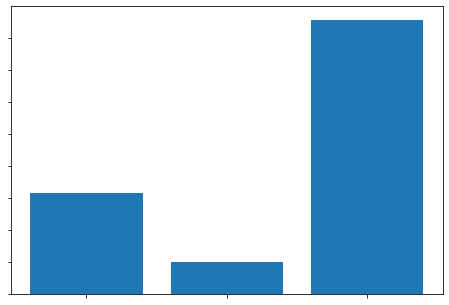

In [77]:
cph = {'filename': [], 'target': []}

# covid/pneumonia data
for image in data:
    # skip volume data
    if image[22] == "volumes":
        continue
    
    # ignore CT scan data
    if image[19] == "CT":
        continue
    
    diagnosis1 = image[4].split("/")
    diagnosis = diagnosis1[len(diagnosis1) - 1].lower()
    # set target based on meta data
    if diagnosis == "covid-19":
        # if it is COVID-19
        cph['filename'].append(image[23])
        cph['target'].append(1)
        
# pneumonia from pneumonia/healthy
for file in ph_files:
    dir_path = os.path.abspath(os.getcwd())
    dir_path = dir_path + "/chest_xray/" + file[0]
    list = os.listdir(dir_path)
    for pic in list:
        if '.DS_Store' not in pic:
            cph['filename'].append(pic)
            if 'pneumonia' in file[0].lower():
                cph['target'].append(2)
            else:
                cph['target'].append(0)

# get distribution
labels = {0: "Healthy", 1: "COVID", 2: "Pneumonia"}
get_distr(cph['target'], labels)


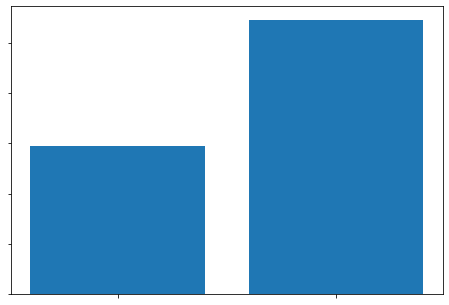

In [78]:
cc = {'filename': [], 'target': []}

# covid/pneumonia data
for image in data:
    # skip volume data
    if image[22] == "volumes":
        continue
    
    # ignore CT scan data
    if image[19] == "CT":
        continue
    
    diagnosis1 = image[4].split("/")
    diagnosis = diagnosis1[len(diagnosis1) - 1].lower()
    # set target based on meta data
    if diagnosis == "covid-19":
        # if it is COVID-19
        if image[7] == "Y":
            # patient intubated
            cc['filename'].append(image[23])
            cc['target'].append(1)
        elif image[7] == "N":
            # patient not intubated
            cc['filename'].append(image[23])
            cc['target'].append(0)


# get distribution
labels = {0: "COVID Not Intubated", 1: "COVID Intubated"}
get_distr(cc['target'], labels)

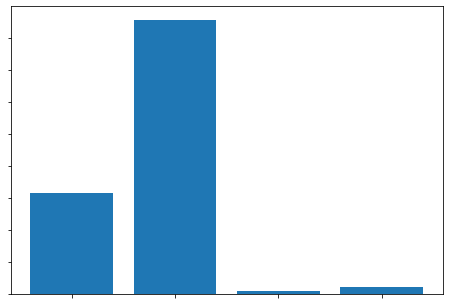

In [79]:
ccph = {'filename': [], 'target': []}

# covid/pneumonia data
for image in data:
    # skip volume data
    if image[22] == "volumes":
        continue
    
    # ignore CT scan data
    if image[19] == "CT":
        continue
    
    diagnosis1 = image[4].split("/")
    diagnosis = diagnosis1[len(diagnosis1) - 1].lower()
    # set target based on meta data
    if diagnosis == "covid-19":
        # if it is COVID-19
        if image[7] == "Y":
            # patient intubated
            ccph['filename'].append(image[23])
            ccph['target'].append(3)
        elif image[7] == "N":
            # patient not intubated
            ccph['filename'].append(image[23])
            ccph['target'].append(2)
            
# pneumonia from pneumonia/healthy
for file in ph_files:
    dir_path = os.path.abspath(os.getcwd())
    dir_path = dir_path + "/chest_xray/" + file[0]
    list = os.listdir(dir_path)
    for pic in list:
        if '.DS_Store' not in pic:
            cph['filename'].append(pic)
            if 'pneumonia' in file[0].lower():
                ccph['target'].append(1)
            else:
                ccph['target'].append(0)

# get distribution
labels = {0: "Healthy", 1: "Pneumonia", 2: "COVID Not Intubated", 3: "COVID Intubated"}
get_distr(ccph['target'], labels)

Plan:
1. COVID/Healthy
2. COVID/Pneumonia
3. COVID/Pneumonia/Healthy
4. COVID Not Intubated/COVID Intubated

Test on (use Random Search CV for Hyper Params)
1. Deep CNN

Test Each with
1. Not augmented
2. Augmented

## Create Model

In [80]:
def create_model(num_classes=2, lr=0.001, do=0.2, layer_size=1024):
    act = 'softmax'
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    metrics = ['accuracy']
    
    if num_classes == 2:
        num_classes = 1
        act = 'sigmoid'
        loss = tf.keras.losses.BinaryCrossentropy()
        metrics = [tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
        
    base_model = tf.keras.applications.VGG19(weights='imagenet', 
                                             include_top=False,
                                             input_shape=(224, 224, 3),
                                             classifier_activation=act)
    
    base_model.trainable = False

    flatten = layers.Flatten()(base_model.layers[-1].output)
    dense = layers.Dense(layer_size, activation='relu')(flatten)
    output = layers.Dense(num_classes, activation=act)(dense)
    
    # define new model
    model = tf.keras.Model(inputs=base_model.inputs, outputs=output)

    opt = tf.keras.optimizers.Adam(lr=lr)
    # compile 
    model.compile(optimizer=opt,
                  loss=loss,
                  metrics=metrics)
    
    return model 

# Hyper Parameter Selection for models

In [59]:
# make classifier
covid_test_model = KerasClassifier(
    build_fn=create_model,
    lr=0.001,
    do=0.2,
    layer_size=1024,
    num_classes=2
)

# random search http://ethen8181.github.io/machine-learning/keras/nn_keras_hyperparameter_tuning.html
learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01]
dropout_rates = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]
dif_layers = [32, 64, 128, 256, 512, 1024]
distributions = dict(layer_size=dif_layers, 
                     do=dropout_rates, 
                     lr=learning_rates)

clf = RandomizedSearchCV(covid_test_model, distributions, random_state=0, n_jobs=None, 
                         scoring="roc_auc", verbose=10, cv=2)
search = clf.fit(cp_images, cp['target'])
search.best_params_

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] lr=0.005, layer_size=1024, do=0.6 ...............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


75/75 [==============================] - 326s 4s/step - loss: 0.0119 - recall_4: 0.0000e+00 - precision_4: 0.0000e+00


AttributeError: 'Functional' object has no attribute 'predict_proba'

In [45]:
lr = 0.001
do = 0.2
bs = 16
threshold = 0.5


# early stopping
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0.01,
        patience=2,
        verbose=1
    )
]  

# Part 1: VGG19 No Augmentation

## 1. COVID/Healthy

In [30]:
ch_images = normalize_images(ch, "all_images/")

KeyboardInterrupt: 

In [ ]:
chx_train, chy_train, chx_val, chy_val, chx_test, chy_test = split_data(ch_images, ch['target'], .2)

In [ ]:
ch_model = create_model(num_classes=2)

ch_history = ch_model.fit(chx_train, np.asarray(chy_train), epochs=10,
                               validation_data=(chx_val, chy_val),
                               batch_size=bs,
                               callbacks=callbacks
                               )

In [ ]:
# save model
cp_model.save('models/ch_model')

In [ ]:
chy_pred = ch_model.predict(chx_test)

In [147]:
chy_pred_norm = convert_pred(chy_pred, threshold)

In [107]:
print(classification_report(chy_test, chy_pred_norm))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       315
           1       0.96      0.99      0.98       103

    accuracy                           0.99       418
   macro avg       0.98      0.99      0.98       418
weighted avg       0.99      0.99      0.99       418



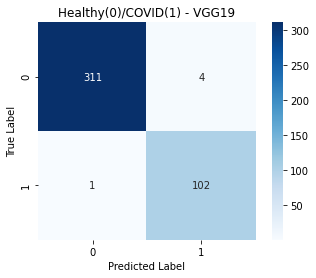

In [191]:
plot_cm(chy_test, chy_pred_norm, "Healthy(0)/COVID(1)")

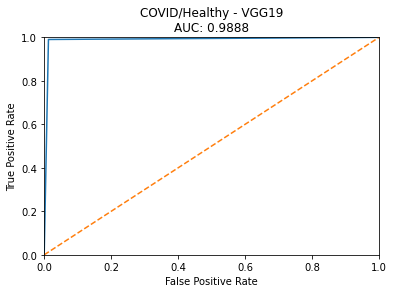

In [192]:
plot_ROC(chy_test, chy_pred, "COVID/Healthy - VGG19")

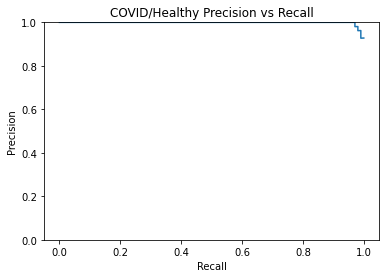

In [193]:
plot_pr(chy_test, chy_pred, "COVID/Healthy")

## 2. COVID/Pneumonia

In [48]:
cp_images = normalize_images(cp, "all_images/")

In [56]:
cpx_train, cpy_train, cpx_val, cpy_val, cpx_test, cpy_test = split_data(cp_images, cp['target'], .2)

In [57]:
cp_model = create_model(2)

In [58]:
cp_history = cp_model.fit(cpx_train, np.asarray(cpy_train), epochs=10,
                               validation_data=(cpx_val, cpy_val),
                               batch_size=bs,
                               callbacks=callbacks
                               )

Epoch 1/10
 66/191 [=========>....................] - ETA: 4:02 - loss: 1.0716 - recall_3: 0.6870 - precision_3: 0.6583

KeyboardInterrupt: 

In [51]:
cp_history = cp_model.fit(cpx_train, np.asarray(cpy_train), epochs=10,
                               validation_data=(cpx_val, cpy_val),
                               batch_size=bs,
                               callbacks=callbacks
                               )

Epoch 1/10
96/96 [==============================] - 349s 4s/step - loss: 1.0067 - recall_9: 0.7382 - precision_9: 0.7267 - val_loss: 0.0266 - val_recall_9: 0.9756 - val_precision_9: 0.9524
Epoch 2/10
96/96 [==============================] - 355s 4s/step - loss: 0.0260 - recall_9: 0.9527 - precision_9: 0.9618 - val_loss: 0.0255 - val_recall_9: 0.9390 - val_precision_9: 0.9872
Epoch 00002: early stopping


In [ ]:
# save model
ch_model.save('models/cp_model')

In [54]:
cpy_pred = cp_model.predict(cpx_test)

In [55]:
cpy_pred_norm = convert_pred(cpy_pred, threshold)

In [56]:
print(classification_report(cpy_test, cpy_pred_norm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       851
           1       0.99      0.97      0.98       105

    accuracy                           1.00       956
   macro avg       0.99      0.99      0.99       956
weighted avg       1.00      1.00      1.00       956



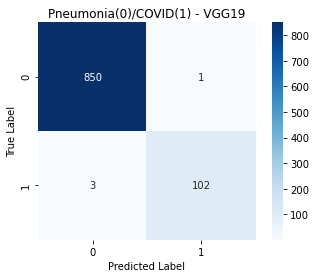

In [64]:
plot_cm(cpy_test, cpy_pred_norm, "Pneumonia(0)/COVID(1) - VGG19")

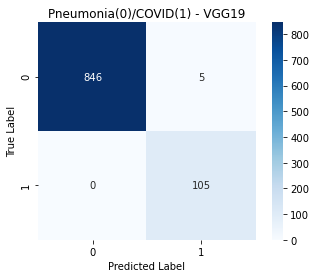

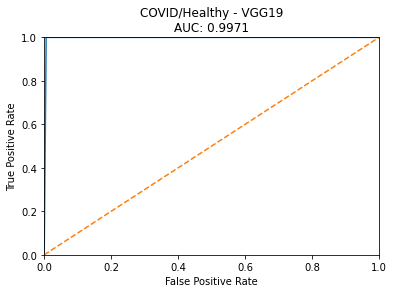

In [195]:
plot_ROC(cpy_test, cpy_pred_norm.ravel(), "COVID/Healthy - VGG19")

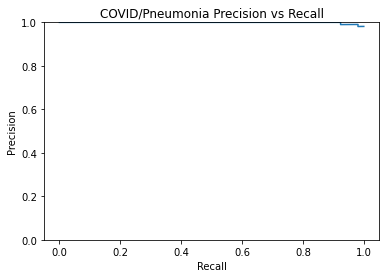

In [196]:
plot_pr(cpy_test, cpy_pred, "COVID/Pneumonia")

## 3. COVID/Pnuemonia/Healthy

In [19]:
cph_images = normalize_images(cph, "all_images/")

In [33]:
cphx_train, cphy_train, cphx_val, cphy_val, cphx_test, cphy_test = split_data(cph_images, cph['target'], .2)

In [65]:
cph_model = create_model(3)

cph_history = cph_model.fit(cphx_train, np.asarray(cphy_train), epochs=10,
                               validation_data=(cphx_val, cphy_val),
                               batch_size=bs,
                               callbacks=callbacks
                               )

Epoch 1/10
128/128 [==============================] - 455s 4s/step - loss: 1.0449 - accuracy: 0.8889 - val_loss: 0.1683 - val_accuracy: 0.9479
Epoch 2/10
128/128 [==============================] - 453s 4s/step - loss: 0.1548 - accuracy: 0.9563 - val_loss: 0.1634 - val_accuracy: 0.9499
Epoch 3/10
128/128 [==============================] - 449s 4s/step - loss: 0.1360 - accuracy: 0.9553 - val_loss: 0.1423 - val_accuracy: 0.9568
Epoch 4/10
128/128 [==============================] - 444s 3s/step - loss: 0.0711 - accuracy: 0.9749 - val_loss: 0.2388 - val_accuracy: 0.9411
Epoch 5/10
128/128 [==============================] - 415s 3s/step - loss: 0.0531 - accuracy: 0.9806 - val_loss: 0.1326 - val_accuracy: 0.9558
Epoch 00005: early stopping


In [75]:
# save model
cph_model.save('models/cph_model')

Epoch 1/10
128/128 [==============================] - 703s 5s/step - loss: 0.8853 - accuracy: 0.6649 - val_loss: 0.8658 - val_accuracy: 0.6857
Epoch 2/10
128/128 [==============================] - 666s 5s/step - loss: 0.8822 - accuracy: 0.6693 - val_loss: 0.8658 - val_accuracy: 0.6857
Epoch 3/10
128/128 [==============================] - 707s 6s/step - loss: 0.8822 - accuracy: 0.6693 - val_loss: 0.8658 - val_accuracy: 0.6857
Epoch 00003: early stopping


In [66]:
cphy_pred = cph_model.predict(cphx_test)

In [67]:
cphy_pred_norm = np.empty(cphy_test.size, dtype='int32')

for i in range(cphy_test.size):
    ind = np.argmax(cphy_pred[i])
    cphy_pred_norm[i] = ind

[2.3427291e-01 1.9874730e-07 7.6572686e-01]
[1.0680363e-05 2.6940006e-10 9.9998927e-01]
[0.00485693 0.00847831 0.9866648 ]
[9.9839526e-01 2.0207784e-09 1.6047033e-03]
[8.2819068e-05 3.2691787e-08 9.9991715e-01]
[1.987981e-04 5.173966e-06 9.997961e-01]
[1.9840003e-05 2.0799769e-06 9.9997807e-01]
[2.7497260e-06 5.1115192e-09 9.9999726e-01]
[9.9999261e-01 6.1773350e-11 7.4085524e-06]
[8.364618e-05 6.283942e-08 9.999163e-01]
[1.27632255e-02 3.96948309e-07 9.87236381e-01]
[2.2756094e-06 3.1267945e-08 9.9999774e-01]
[1.0052743e-02 1.3274823e-05 9.8993403e-01]
[2.5393825e-02 2.3425009e-09 9.7460622e-01]
[7.2520093e-06 5.0140489e-08 9.9999273e-01]
[6.5584545e-06 3.8667491e-07 9.9999309e-01]
[3.6147363e-02 9.6299982e-07 9.6385163e-01]
[1.6879503e-04 6.4452493e-06 9.9982482e-01]
[1.3800696e-06 3.6555849e-04 9.9963307e-01]
[9.0105283e-01 5.2832142e-08 9.8947234e-02]
[2.1558185e-06 2.4233241e-05 9.9997365e-01]
[2.9882510e-06 2.5919452e-04 9.9973780e-01]
[1.0000000e+00 1.2341283e-12 5.8388828e-08]


[1.42885965e-05 1.13439858e-09 9.99985695e-01]
[9.9998319e-01 1.4774737e-11 1.6809166e-05]
[3.142182e-04 3.701924e-04 9.993156e-01]
[7.809455e-04 1.447435e-06 9.992176e-01]
[1.3646383e-08 9.9982017e-01 1.7980635e-04]
[9.9999988e-01 1.6952102e-12 1.3585831e-07]
[1.6532398e-05 1.8445455e-07 9.9998331e-01]
[3.5841588e-04 2.6318057e-05 9.9961519e-01]
[2.3272477e-01 3.6349937e-07 7.6727492e-01]
[6.2060077e-05 1.6972665e-08 9.9993789e-01]
[2.8471892e-09 9.9999785e-01 2.1936939e-06]
[2.4268568e-04 4.4072912e-08 9.9975723e-01]
[6.426350e-04 5.893908e-09 9.993574e-01]
[4.8458037e-06 1.2179247e-07 9.9999499e-01]
[1.3580289e-02 2.1759872e-07 9.8641950e-01]
[3.1642344e-02 6.0623427e-07 9.6835709e-01]
[6.6021785e-05 8.9067548e-08 9.9993384e-01]
[9.9999511e-01 8.0818141e-10 4.9369705e-06]
[9.7999889e-01 3.1381649e-06 1.9997999e-02]
[9.9878830e-01 1.2152177e-09 1.2117242e-03]
[9.9619919e-01 3.4451873e-06 3.7973456e-03]
[8.2452238e-01 5.6425232e-08 1.7547755e-01]
[1.9334268e-03 1.9919543e-07 9.9806637

In [68]:
print(classification_report(cphy_test, cphy_pred_norm))

              precision    recall  f1-score   support

           0       0.94      0.91      0.93       314
           1       0.96      1.00      0.98       107
           2       0.97      0.98      0.97       851

    accuracy                           0.96      1272
   macro avg       0.96      0.96      0.96      1272
weighted avg       0.96      0.96      0.96      1272



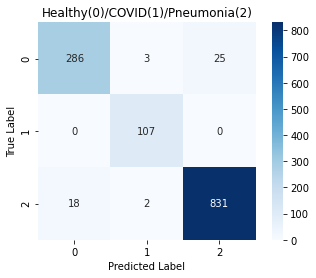

In [69]:
plot_cm(cphy_test, cphy_pred_norm, "Healthy(0)/COVID(1)/Pneumonia(2)")

## 4. COVID Not Intubated/COVID Intubated

In [82]:
cc_images = normalize_images(cc, "all_images/")

In [97]:
ccx_train, ccy_train, ccx_val, ccy_val, ccx_test, ccy_test = split_data(cc_images, cc['target'], .2)

In [98]:
cc_model = create_model(2)

cc_history = cc_model.fit(ccx_train, np.asarray(ccy_train), epochs=10,
                               validation_data=(ccx_val, ccy_val),
                               batch_size=bs,
                               callbacks=callbacks
                               )

Epoch 1/10
7/7 [==============================] - 17s 2s/step - loss: 7.6693 - recall_6: 0.4493 - precision_6: 0.6327 - val_loss: 1.3902 - val_recall_6: 1.0000 - val_precision_6: 0.6000
Epoch 2/10
7/7 [==============================] - 18s 3s/step - loss: 1.2286 - recall_6: 0.9565 - precision_6: 0.7097 - val_loss: 1.6183 - val_recall_6: 0.0667 - val_precision_6: 1.0000
Epoch 3/10
7/7 [==============================] - 18s 3s/step - loss: 0.8965 - recall_6: 0.6377 - precision_6: 0.8000 - val_loss: 1.7391 - val_recall_6: 1.0000 - val_precision_6: 0.6000
Epoch 00003: early stopping


In [99]:
ccy_pred = cc_model.predict(ccx_test)

In [100]:
ccy_pred_norm = convert_pred(ccy_pred, threshold)

In [101]:
print(classification_report(ccy_test, ccy_pred_norm))

              precision    recall  f1-score   support

           0       1.00      0.11      0.20         9
           1       0.76      1.00      0.86        25

    accuracy                           0.76        34
   macro avg       0.88      0.56      0.53        34
weighted avg       0.82      0.76      0.69        34



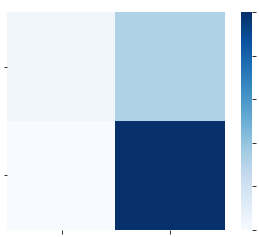

In [102]:
plot_cm(ccy_test, ccy_pred_norm, "COVID Not Intubated(0)/COVID Intubated(1) - VGG19")

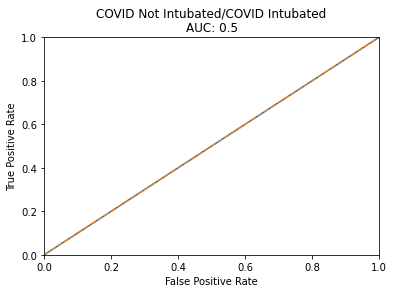

In [70]:
plot_ROC(ccy_test, ccy_pred_norm.ravel(), "COVID Not Intubated/COVID Intubated")

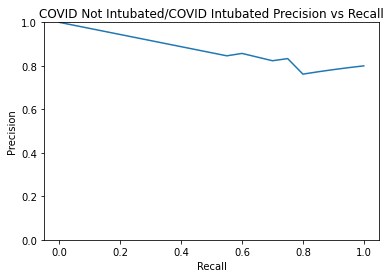

In [71]:
plot_pr(ccy_test, ccy_pred, "COVID Not Intubated/COVID Intubated")

# Part 1: VGG19 With Augmentation

## 1. COVID Not Intubated/COVID Intubated Augmented

In [83]:
ccax_train, ccay_train, ccax_val, ccay_val, ccax_test, ccay_test = split_data(cc_images, cc['target'], .2)

In [84]:
ccax_train, ccay_train = augment_images(ccax_train, ccay_train)

In [85]:
cca_model = create_model(2)

cca_history = cca_model.fit(ccax_train, np.asarray(ccay_train), epochs=10,
                               validation_data=(ccax_val, ccay_val),
                               batch_size=bs,
                               callbacks=callbacks
                               )

Epoch 1/10
107/107 [==============================] - 261s 2s/step - loss: 1.2323 - recall_5: 0.8388 - precision_5: 0.7942 - val_loss: 0.5314 - val_recall_5: 0.8000 - val_precision_5: 0.7500
Epoch 2/10
107/107 [==============================] - 266s 2s/step - loss: 0.1903 - recall_5: 0.9846 - precision_5: 0.9259 - val_loss: 0.6419 - val_recall_5: 0.9333 - val_precision_5: 0.6667
Epoch 3/10
107/107 [==============================] - 298s 3s/step - loss: 0.1131 - recall_5: 0.9855 - precision_5: 0.9577 - val_loss: 0.5261 - val_recall_5: 0.8000 - val_precision_5: 0.7500
Epoch 00003: early stopping


In [95]:
# save model
cca_model.save('models/cca_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/cca_model/assets


In [86]:
ccay_pred = cca_model.predict(ccax_test)

In [87]:
ccay_pred_norm = convert_pred(ccay_pred, threshold)

In [89]:
print(classification_report(ccay_test, ccay_pred_norm))

              precision    recall  f1-score   support

           0       0.47      0.78      0.58         9
           1       0.89      0.68      0.77        25

    accuracy                           0.71        34
   macro avg       0.68      0.73      0.68        34
weighted avg       0.78      0.71      0.72        34



In [91]:
print(classification_report(ccay_test, ccay_pred_norm))

              precision    recall  f1-score   support

           0       0.50      0.56      0.53         9
           1       0.83      0.80      0.82        25

    accuracy                           0.74        34
   macro avg       0.67      0.68      0.67        34
weighted avg       0.75      0.74      0.74        34



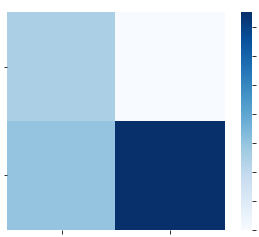

In [96]:
plot_cm(ccay_test, ccay_pred_norm, "COVID Not Intubated(0)/COVID Intubated(1) - Augmented")

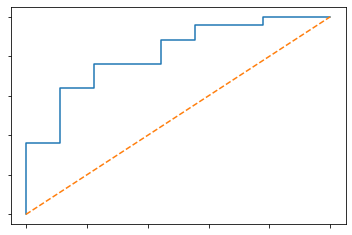

In [94]:
plot_ROC(ccay_test, ccay_pred, "COVID Not Intubated/COVID Intubated - Augmented")

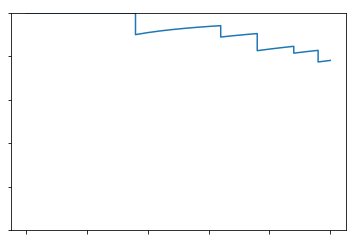

In [92]:
plot_pr(ccay_test, ccay_pred, "COVID Not Intubated/COVID Intubated - Augmented")

## 2. COVID/Pneumonia/Healthy Augmented

In [ ]:
cphax_train, cphay_train, cphax_val, cphay_val, cphax_test, cphay_test = split_data(cph_images, cph['target'], .2)

In [ ]:
cphax_train, cphay_train = augment_images(cphax_train, cphay_train)

In [ ]:
cpha_model = create_model(3)

cpha_history = cpha_model.fit(cphax_train, np.asarray(cphay_train), epochs=10,
                               validation_data=(cphax_val, cphay_val),
                               batch_size=bs,
                               callbacks=callbacks
                               )

In [ ]:
# save model
cpha_model.save('models/cpha_model')

In [ ]:
cphay_pred = cpha_model.predict(cphax_test)

In [ ]:
cphay_pred_norm = np.empty(cphay_test.size, dtype='int32')

for i in range(cphay_test.size):
    ind = np.argmax(cphay_pred[i])
    cphay_pred_norm[i] = ind

In [ ]:
print(classification_report(cphay_test, cphay_pred_norm))

In [ ]:
plot_cm(cphy_test, cphy_pred_norm, "Healthy(0)/COVID(1)/Pneumonia(2) Augmented")